In [54]:
from enterprise.pulsar import Pulsar
from enterprise.signals.signal_base import PTA
from enterprise.signals.white_signals import MeasurementNoise
from enterprise.signals.gp_signals import MarginalizingTimingModel
from enterprise_extensions.blocks import red_noise_block, dm_noise_block

from PTMCMCSampler.PTMCMCSampler import PTSampler

from pint.models import get_model_and_toas, get_model
from pint.utils import pldmnoise_from_dmwavex, plrednoise_from_wavex
from pint import DMconst
from pint.logging import setup as setup_log
from pint.residuals import Residuals

from astropy import units as u
import numpy as np
import corner
import matplotlib.pyplot as plt

from copy import deepcopy

In [3]:
setup_log(level="WARNING")

1

In [4]:
psr = Pulsar("sim5.par", "sim5.tim", timing_package="pint")

In [5]:
tm = MarginalizingTimingModel()
wn = MeasurementNoise(efac=1)
rn = red_noise_block(components=7)
dmn = dm_noise_block(components=5)

In [6]:
signal = tm + wn + dmn + rn

In [7]:
pta = PTA([signal(psr)])

In [8]:
pta.param_names

['SIM3_dm_gp_gamma',
 'SIM3_dm_gp_log10_A',
 'SIM3_red_noise_gamma',
 'SIM3_red_noise_log10_A']

In [12]:
ndim = len(pta.param_names)
x0 = np.array(
    # [4, -13.5, 3.5, -13.0]
    [p.sample() for p in pta.params]
)
cov = np.diag(np.ones(ndim)) * 1e-4
outdir = "chains/"
Niter = 200000

In [13]:
sampler = PTSampler(
    ndim,
    pta.get_lnlikelihood,
    pta.get_lnprior,
    cov,
    outDir=outdir,
)

In [14]:
sampler.sample(
    x0,
    Niter,
)

Finished 5.00 percent in 2.457322 s Acceptance rate = 0.262111Adding DE jump with weight 20
Finished 100.00 percent in 47.133008 s Acceptance rate = 0.37869
Run Complete


In [15]:
chain = np.genfromtxt(f"{outdir}/chain_1.txt")
burn = chain.shape[0]//5
burned_chain = chain[burn:, :-4]

In [16]:
gamma_dm, log10_A_dm, gamma_red, log10_A_red = np.median(burned_chain, axis=0)

In [17]:
m_wx, t = get_model_and_toas("sim5.wx.par", "sim5.tim")

In [18]:
m_pint = plrednoise_from_wavex(pldmnoise_from_dmwavex(m_wx))

In [43]:
scale = DMconst / (1400 * u.MHz)**2

idxs = np.array(m_wx.components["DMWaveX"].get_indices())
ad = np.array([(scale*m_wx[f"DMWXSIN_{idx:04d}"].quantity).to_value("s") for idx in idxs])
dad = np.array([(scale*m_wx[f"DMWXSIN_{idx:04d}"].uncertainty).to_value("s") for idx in idxs])
bd = np.array([(scale*m_wx[f"DMWXCOS_{idx:04d}"].quantity).to_value("s") for idx in idxs])
dbd = np.array([(scale*m_wx[f"DMWXCOS_{idx:04d}"].uncertainty).to_value("s") for idx in idxs])
fd = np.array([(m_wx[f"DMWXFREQ_{idx:04d}"].quantity).to_value("Hz") for idx in idxs])

Pd = (ad**2 + bd**2) / 2
dPd = ((ad*dad)**2 + (bd*dbd)**2)**0.5

# ===========================

scale = 1
idxs = np.array(m_wx.components["WaveX"].get_indices())
ar = np.array([(scale*m_wx[f"WXSIN_{idx:04d}"].quantity).to_value("s") for idx in idxs])
dar = np.array([(scale*m_wx[f"WXSIN_{idx:04d}"].uncertainty).to_value("s") for idx in idxs])
br = np.array([(scale*m_wx[f"WXCOS_{idx:04d}"].quantity).to_value("s") for idx in idxs])
dbr = np.array([(scale*m_wx[f"WXCOS_{idx:04d}"].uncertainty).to_value("s") for idx in idxs])
fr = np.array([(m_wx[f"WXFREQ_{idx:04d}"].quantity).to_value("Hz") for idx in idxs])

Pr = (ar**2 + br**2) / 2
dPr = ((ar*dar)**2 + (br*dbr)**2)**0.5



In [44]:
m_inj = get_model("sim5.par")

m_ent = deepcopy(m_inj)
m_ent.TNREDAMP.value = log10_A_red
m_ent.TNREDGAM.value = gamma_red
m_ent.TNDMAMP.value = log10_A_dm
m_ent.TNDMGAM.value = gamma_dm

In [45]:
Pd_pint = m_pint.components["PLDMNoise"].get_noise_weights(t)[::2]
Pd_inj = m_inj.components["PLDMNoise"].get_noise_weights(t)[::2][:len(fd)]
Pd_ent = m_ent.components["PLDMNoise"].get_noise_weights(t)[::2][:len(fd)]

Pr_pint = m_pint.components["PLRedNoise"].get_noise_weights(t)[::2]
Pr_inj = m_inj.components["PLRedNoise"].get_noise_weights(t)[::2][:len(fr)]
Pr_ent = m_ent.components["PLRedNoise"].get_noise_weights(t)[::2][:len(fr)]

In [46]:
fyr = (1/u.year).to("Hz")

In [47]:
fyr.value

3.168808781402895e-08

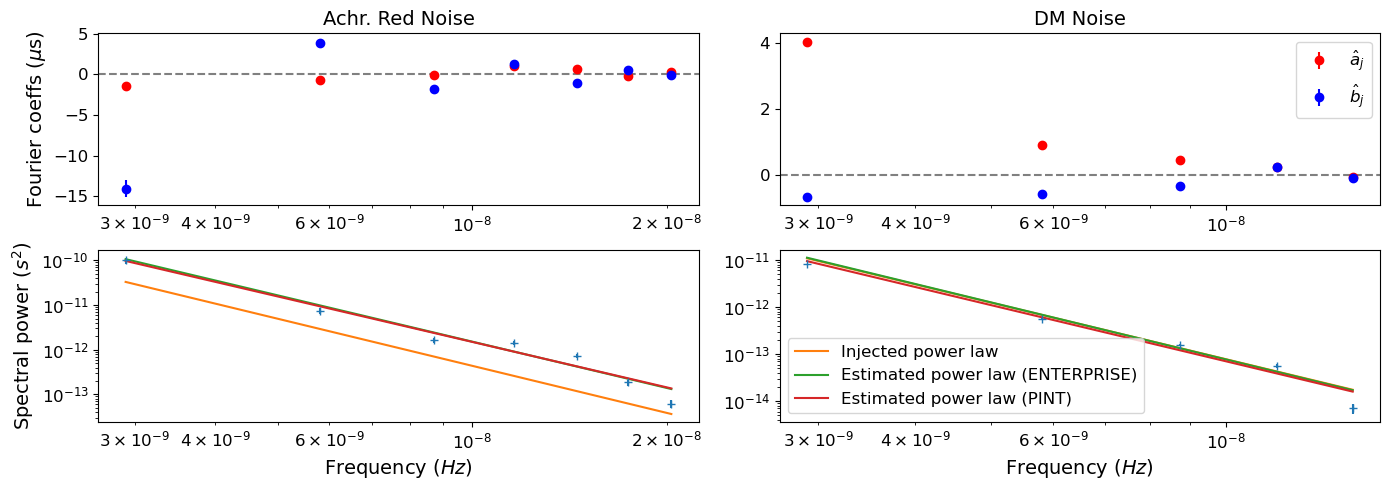

In [77]:
plt.figure(figsize=(14, 5))

plt.subplot(221)
plt.errorbar(fr, ar*1e6, dar*1e6, marker="o", ls="", label="$\\hat{a}_j$", color="red")
plt.errorbar(fr, br*1e6, dbr*1e6, marker="o", ls="", label="$\\hat{b}_j$", color="blue")
plt.xscale("log")
plt.ylabel("Fourier coeffs ($\mu$s)", fontsize=14)
plt.axhline(0, ls="--", color="grey")
# plt.legend()
plt.title("Achr. Red Noise", fontsize=14)
# plt.axvline(fyr.value, ls="dotted", color="black")
plt.tick_params(axis="both", which="both", labelsize=12)

plt.subplot(222)
plt.errorbar(fd, ad*1e6, dad*1e6, marker="o", ls="", label="$\\hat{a}_j$", color="red")
plt.errorbar(fd, bd*1e6, dbd*1e6, marker="o", ls="", label="$\\hat{b}_j$", color="blue")
plt.axhline(0, ls="--", color="grey")
plt.xscale("log")
plt.legend(fontsize=12)
plt.title("DM Noise", fontsize=14)
plt.tick_params(axis="both", which="both", labelsize=12)

plt.subplot(223)
plt.errorbar(fr, Pr, dPr, ls="", marker="+")
plt.plot(fr, Pr_inj, label="Injection")
plt.plot(fr, Pr_ent, label="ENTERPRISE")
plt.plot(fr, Pr_pint, label="PINT")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Spectral power ($s^2$)", fontsize=14)
plt.xlabel("Frequency ($Hz$)", fontsize=14)
plt.tick_params(axis="both", which="both", labelsize=12)

plt.subplot(224)
plt.errorbar(fd, Pd, dPd, ls="", marker="+")
plt.plot(fd, Pd_inj, label="Injected power law")
plt.plot(fd, Pd_ent, label="Estimated power law (ENTERPRISE)")
plt.plot(fd, Pd_pint, label="Estimated power law (PINT)")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency ($Hz$)", fontsize=14)
plt.legend(fontsize=12)
plt.tick_params(axis="both", which="both", labelsize=12)

plt.tight_layout()

plt.savefig("sim5-spec.pdf")

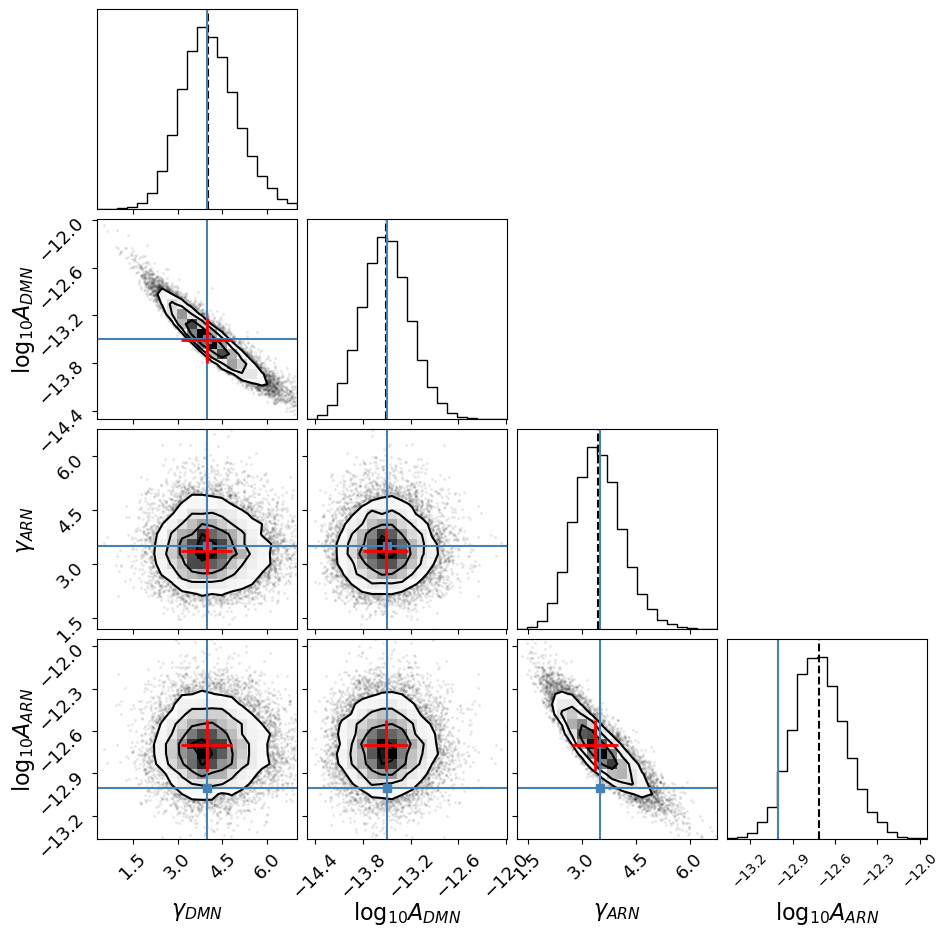

In [63]:
true_params = [
    m_inj.TNDMGAM.value, 
    m_inj.TNDMAMP.value, 
    m_inj.TNREDGAM.value, 
    m_inj.TNREDAMP.value
]

pint_params = [
    m_pint.TNDMGAM.value, 
    m_pint.TNDMAMP.value, 
    m_pint.TNREDGAM.value, 
    m_pint.TNREDAMP.value
]

pint_errors = [
    m_pint.TNDMGAM.uncertainty_value, 
    m_pint.TNDMAMP.uncertainty_value, 
    m_pint.TNREDGAM.uncertainty_value, 
    m_pint.TNREDAMP.uncertainty_value
]

labels = [
    "$\\gamma_{DMN}$",
    "$\\log_{10} A_{DMN}$",
    "$\\gamma_{ARN}$",
    "$\\log_{10} A_{ARN}$"
]

fig = corner.corner(
    burned_chain, 
    labels=labels, 
    truths=[4, -13.5, 3.5, -13.0],
    quantiles=[0.5],
    label_kwargs={"fontsize": 16}
)

for i in range(ndim):
    x = pint_params[i]
    dx = pint_errors[i]
    for j in range(i+1, ndim):
        y = pint_params[j]
        dy = pint_errors[j]
        
        try:
            plt.subplot(ndim, ndim, i + ndim*j + 1)
            plt.errorbar(x=[x], y=[y], xerr=[dx], yerr=[dy], color="red", elinewidth=2)

            plt.tick_params(labelsize=13)
        except:
            print(i, j, )

plt.savefig("sim5-params.pdf")

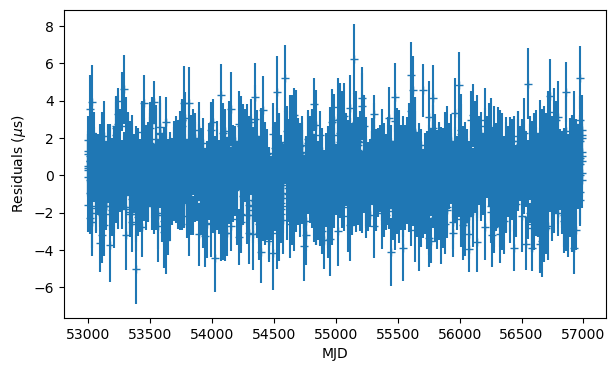

In [58]:
res = Residuals(t, m_wx)
tmjd = t.get_mjds().value
r = res.calc_time_resids().to_value("us")
terr = res.get_data_error().to_value("us")

plt.figure(figsize=(7, 4))
plt.errorbar(tmjd, r, terr, marker="+", ls="")
plt.xlabel("MJD")
plt.ylabel("Residuals ($\\mu$s)")

plt.savefig("sim5-resids.pdf")

In [68]:
pint_params

[3.970341976583563,
 -13.514749978162524,
 3.378323112319773,
 -12.701817203529187]

In [71]:
np.median(burned_chain, axis=0)

array([  3.86700966, -13.43385495,   3.29409246, -12.69905282])